In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
#from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [4]:
import os
import cv2
import numpy as np
from random import randint

# Define the path to your dataset folder
dataset_folder = '/content/drive/MyDrive/Thesis_dataset/DATASET'

# Define the list of classes (subfolders)
classes = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]

# Specify the augmentation parameters
rotation_range = 40  # Maximum rotation angle in degrees
brightness_range = 0.2  # Maximum brightness change
contrast_range = 0.2  # Maximum contrast change
num_augmentations = 10  # Number of augmentations per image

# Create a directory for augmented images
augmented_dataset_folder = 'Augmented_Dataset'
os.makedirs(augmented_dataset_folder, exist_ok=True)

# Loop through each class folder
for class_name in classes:
    class_folder = os.path.join(dataset_folder, class_name)

    # Create a directory for augmented images within the augmented dataset folder
    augmented_class_folder = os.path.join(augmented_dataset_folder, class_name)
    os.makedirs(augmented_class_folder, exist_ok=True)

    # Loop through each image in the class folder
    for filename in os.listdir(class_folder):
        img_path = os.path.join(class_folder, filename)

        # Load the image using OpenCV
        img = cv2.imread(img_path)

        # Apply multiple augmentations
        for i in range(num_augmentations):
            # Apply random rotations
            angle = randint(-rotation_range, rotation_range)
            M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), angle, 1)
            img_rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

            # Apply random brightness and contrast changes
            alpha = 1.0 + np.random.uniform(-brightness_range, brightness_range)
            beta = 0.5 + np.random.uniform(-contrast_range, contrast_range)
            img_augmented = cv2.convertScaleAbs(img_rotated, alpha=alpha, beta=beta)

            # Generate a unique filename for each augmented image
            augmented_filename = os.path.join(augmented_class_folder, f"{filename[:-4]}_{i}.jpg")

            # Save the augmented image
            cv2.imwrite(augmented_filename, img_augmented)

print(f"Data augmentation complete. {num_augmentations} augmented images generated for each image in 'Augmented_Dataset' folder.")


Data augmentation complete. 10 augmented images generated for each image in 'Augmented_Dataset' folder.


In [5]:
import os
import cv2
import numpy as np

# Define the image size (assuming it's 200x200 based on your previous code)
image_size = 200

# Define the list of labels/classes
labels = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

# Initialize lists to store image data and labels
img_data = []
img_labels = []

# Loop through each class
for label in labels:
    folder_path = os.path.join('/content/Augmented_Dataset', label)

    # Loop through each image in the class folder
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)

        # Load the image using OpenCV
        img = cv2.imread(img_path)

        # Resize the image to the specified size
        img = cv2.resize(img, (image_size, image_size))

        # Append the image data to the list
        img_data.append(img)

        # Append the corresponding label to the label list
        img_labels.append(label)

# Convert the lists to NumPy arrays
img_data = np.array(img_data)
img_labels = np.array(img_labels)

# Optionally, you can normalize the image data by dividing by 255 (assuming 8-bit images)
img_data = img_data / 255.0

# Check the shapes of the arrays
print("Image Data Shape:", img_data.shape)
print("Image Labels Shape:", img_labels.shape)


Image Data Shape: (3640, 200, 200, 3)
Image Labels Shape: (3640,)


In [6]:
img_data,img_labels = shuffle(img_data,img_labels,random_state=101)
img_data.shape

(3640, 200, 200, 3)

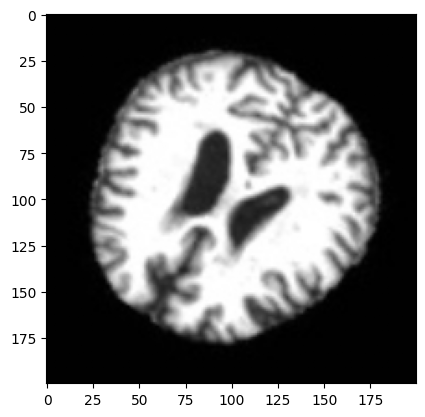

In [7]:
plt.imshow(img_data[1000])

In [8]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(img_data, img_labels, test_size=0.2, random_state=101)

# Define the list of labels/classes
labels = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

# Convert class labels to integers
y_train = [labels.index(label) for label in y_train]
y_test = [labels.index(label) for label in y_test]

# Convert integers to one-hot encoded categorical format
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(labels))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(labels))


In [9]:
X_train.shape

(2912, 200, 200, 3)

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19  # Import VGG19 instead of VGG16
from tensorflow.keras import models
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input  # Use VGG19 preprocess_input
import numpy as np
import os

# Load the pre-trained VGG19 model without the top classification layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(200, 200, 3))  # Use VGG19

# Define the layer from which you want to extract features
flatten_layer = Flatten()
dense_layer = Dense(1024, activation='relu')

model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer
])

model.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 1024)              18875392  
                                                                 
Total params: 38899776 (148.39 MB)
Trainable params: 38899776 (148.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# Define the directory containing your main folder
main_folder = 'Augmented_Dataset'

# Create empty arrays to store extracted features and labels
features_list = []
labels_list = []

# Define a mapping from folder names to integer labels
label_mapping = {
    "Mild_Demented": 0,
    "Moderate_Demented": 1,
    "Non_Demented": 2,
    "Very_Mild_Demented": 3
}

# Iterate over each subfolder
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)

    if os.path.isdir(subfolder_path):
        label = label_mapping.get(subfolder, -1)  # Assign label based on folder name

        if label != -1:
            # Iterate over each image in the subfolder
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.jpg'):
                    img_path = os.path.join(subfolder_path, filename)
                    img = image.load_img(img_path, target_size=(200, 200))
                    x = image.img_to_array(img)
                    x = np.expand_dims(x, axis=0)
                    x = preprocess_input(x)

                    # Extract features using the intermediate layer model
                    features = model.predict(x)

                    # Append features and label to respective lists
                    features_list.append(features)
                    labels_list.append(label)

# Stack the extracted features and labels into numpy arrays
features_array = np.vstack(features_list)
labels_array = np.array(labels_list)

# Create an instance of the RFE class with your chosen estimator (e.g., DecisionTreeClassifier)
# and specify the number of features to select
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=700)

# Fit the RFE model to the features and labels
rfe.fit(features_array, labels_array)

# Get the selected features
selected_features = features_array[:, rfe.support_]


1/1 [==============================] - 0s 19ms/step


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(selected_features, labels_array, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=800, random_state=42)  # You can adjust the number of estimators as needed

# Train the Random Forest classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_mapping.keys())

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)


Accuracy: 0.91
Classification Report:
                     precision    recall  f1-score   support

     Mild_Demented       0.89      0.94      0.92       195
 Moderate_Demented       1.00      0.97      0.99       138
      Non_Demented       0.90      0.87      0.88       217
Very_Mild_Demented       0.88      0.87      0.87       178

          accuracy                           0.91       728
         macro avg       0.91      0.91      0.91       728
      weighted avg       0.91      0.91      0.91       728



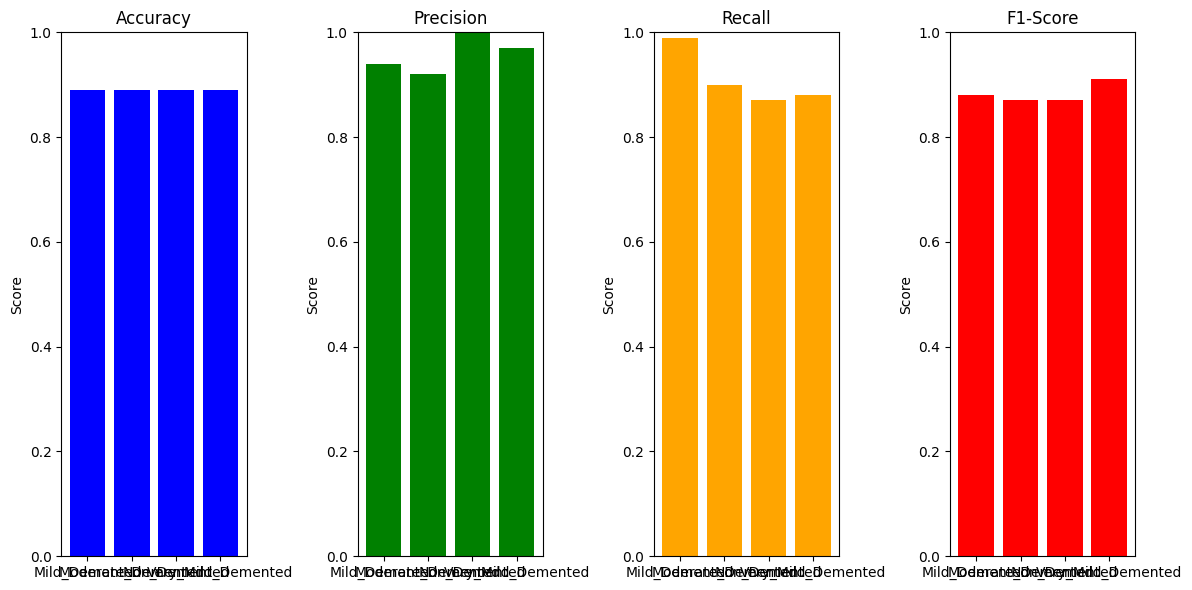

In [13]:

import matplotlib.pyplot as plt
import re
# Extract accuracy, precision, recall, and F1-score values
class_names = list(label_mapping.keys())
metrics = re.findall(r'\d+\.\d+', report)
accuracy = float(metrics[0])
precision = [float(metrics[i]) for i in range(1, 5)]
recall = [float(metrics[i]) for i in range(5, 9)]
f1_score = [float(metrics[i]) for i in range(9, 13)]

# Create bar plots for accuracy, precision, recall, and F1-score
plt.figure(figsize=(12, 6))

# Bar plot for accuracy
plt.subplot(1, 4, 1)
plt.bar(range(1, 5), [accuracy], color='blue')
plt.ylim(0, 1)
plt.title("Accuracy")
plt.ylabel("Score")
plt.xticks(range(1, 5), class_names)

# Bar plot for precision
plt.subplot(1, 4, 2)
plt.bar(range(1, 5), precision, color='green')
plt.ylim(0, 1)
plt.title("Precision")
plt.ylabel("Score")
plt.xticks(range(1, 5), class_names)

# Bar plot for recall
plt.subplot(1, 4, 3)
plt.bar(range(1, 5), recall, color='orange')
plt.ylim(0, 1)
plt.title("Recall")
plt.ylabel("Score")
plt.xticks(range(1, 5), class_names)

# Bar plot for F1-score
plt.subplot(1, 4, 4)
plt.bar(range(1, 5), f1_score, color='red')
plt.ylim(0, 1)
plt.title("F1-Score")
plt.ylabel("Score")
plt.xticks(range(1, 5), class_names)

plt.tight_layout()  # Adjust subplot layout

plt.show()